In [0]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets

from collections import deque

import time


# Exercício sobre busca cega

Para este exercício, vamos implementar alguns mecanismos de busca cega, bem como fazer análises comparativas dos mesmos.

## Algumas funções necessárias para realizar as buscas cegas 

In [0]:
def display_visual(graph_data, algorithm=None, problem=None):
    initial_node_colors = graph_data['node_colors']
    def slider_callback(iteration):
        # don't show graph for the first time running the cell calling this function
        try:
            show_map(graph_data, node_colors=all_node_colors[iteration])
        except:
            pass
    def visualize_callback(Visualize):
        if Visualize is True:
            button.value = False

            global all_node_colors

            iterations, all_node_colors, node = algorithm(problem)
            solution = node.solution()
            all_node_colors.append(final_path_colors(all_node_colors[0], problem, solution))

            slider.max = len(all_node_colors) - 1

            for i in range(slider.max + 1):
                slider.value = i
                 #time.sleep(.5)

    slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
    slider_visual = widgets.interactive(slider_callback, iteration=slider)
    display(slider_visual)

    button = widgets.ToggleButton(value=False)
    button_visual = widgets.interactive(visualize_callback, Visualize=button)
    display(button_visual)
        
def show_map(graph_data, node_colors = None):
    G = nx.Graph(graph_data['graph_dict'])
    node_colors = node_colors or graph_data['node_colors']
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights= graph_data['edge_weights']
    
    # set the size of the plot
    plt.figure(figsize=(18,13))
    # draw the graph (both nodes and edges) with locations from romania_locations
    nx.draw(G, pos={k: node_positions[k] for k in G.nodes()},
            node_color=[node_colors[node] for node in G.nodes()], linewidths=0.3, edgecolors='k')

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos=node_label_pos, font_size=14)
    
    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=14)
    
    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution'),
               numpoints=1, prop={'size':16}, loc=(.8,.75))
    
    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()
    
def final_path_colors(initial_node_colors, problem, solution):
    "Return a node_colors dict of the final path provided the problem and solution."
    
    # get initial node colors
    final_colors = dict(initial_node_colors)
    # color all the nodes in solution and starting node to green
    final_colors[problem.initial] = "green"
    for node in solution:
        final_colors[node] = "green"  
    return final_colors    

In [0]:
class Problem(object):

    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2.  If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value.  Hill-climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError

class GraphProblem(Problem):

    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        Problem.__init__(self, initial, goal)
        self.graph = graph

    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or infinity)

    def find_min_edge(self):
        """Find minimum value of edges."""
        m = infinity
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)

        return m

    def h(self, node):
        """h function is straight-line distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(distance(locs[node], locs[self.goal]))

            return int(distance(locs[node.state], locs[self.goal]))
        else:
            return infinity

In [0]:
class Node:

    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state.  Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node.  Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action,
                    problem.path_cost(self.path_cost, self.state,
                                      action, next_state))
        return next_node
    
    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

class Graph:

    """A graph connects nodes (vertices) by edges (links).  Each edge can also
    have a length associated with it.  The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C.  You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added.  You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B.  'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)        
        
def UndirectedGraph(graph_dict=None):
    """Build a Graph where every edge (including future ones) goes both ways."""
    return Graph(graph_dict = graph_dict, directed=False)

## Mapa que deverá ser percorrido

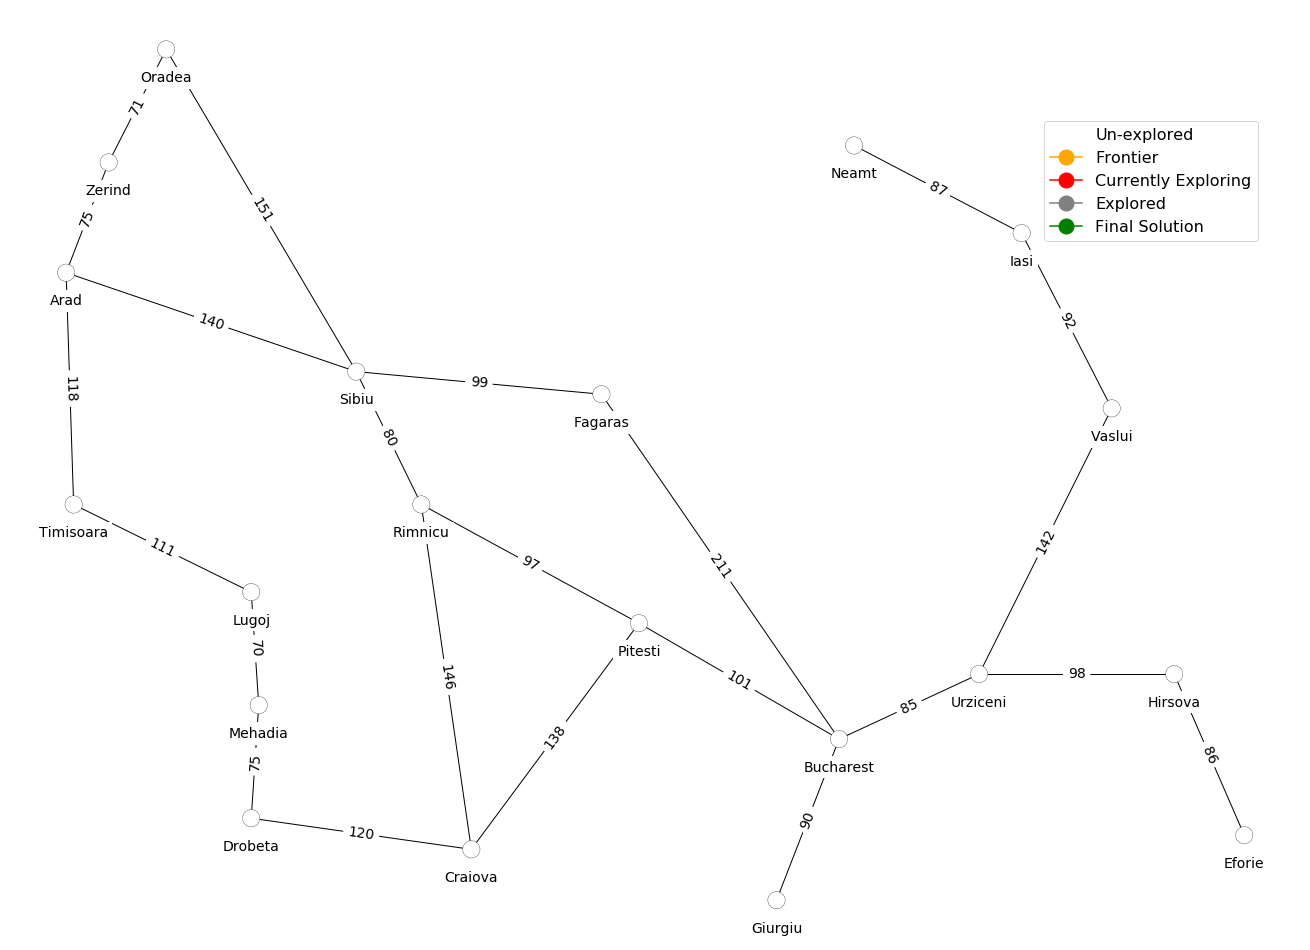

In [5]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))


node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }


show_map(romania_graph_data)

## Busca em profundidade

Primeiramente vamos implementar a busca em profundidade. Note que esta implementação tem uma pequena variação para não visitar novamente as cidades já visitadas, tendo em vista que temos um grafo, não uma árvore.

In [0]:
def graph_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    If two paths reach a state, only use the first one. [Figure 3.7]"""
    # we use these two variables at the time of visualisations
    iterations = 0
    current_node_colors = {}
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier = [(Node(problem.initial))]
    explored = set()
    
    # modify the color of frontier nodes to orange
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    current_node_colors = dict(node_colors)
    
    while frontier:
        # Popping first node of stack
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        current_node_colors = dict(node_colors)
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            current_node_colors = dict(node_colors)
            return(iterations, current_node_colors, node)
        
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
        
        for n in frontier:
            # modify the color of frontier nodes to orange
            node_colors[n.state] = "orange"
            iterations += 1
            current_node_colors = dict(node_colors)

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        current_node_colors = dict(node_colors)
                
    return iterations, current_node_colors, node

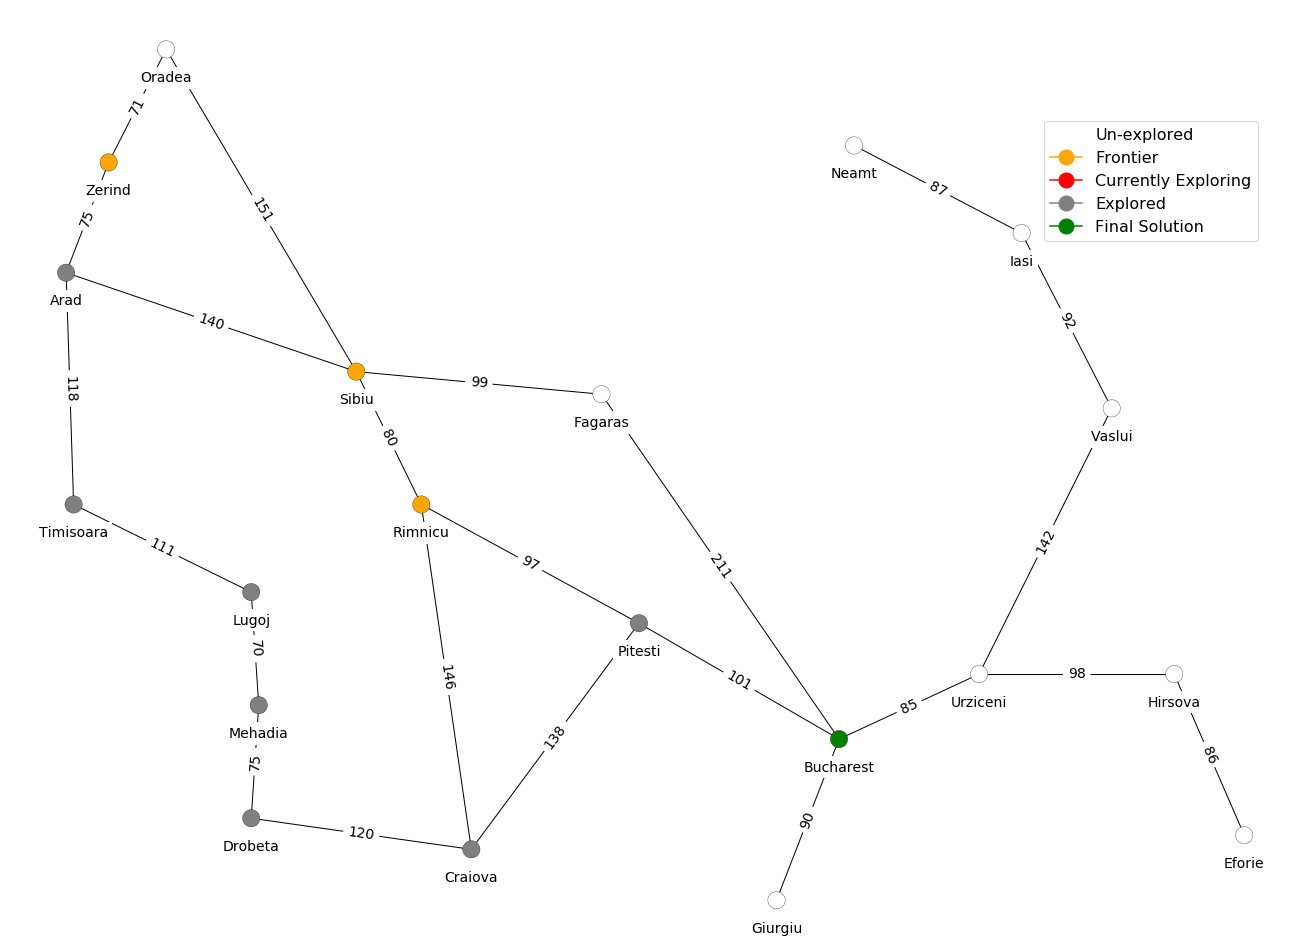

In [7]:
current_node_colors = {}
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

iterations, current_node_colors, node = graph_search_for_vis(romania_problem)

new_romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': current_node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }
show_map(new_romania_graph_data)

Note que as cidades visitadas foram as que estão em cinza, em verde o destino e em laranja as cidades vizinhas fronteiras das que ele passou mas não visitou.

## Busca em largura

Agora vamos implementar a busca em largura, com a mesma restrição anterior.

In [0]:
def breadth_first_search_graph(problem):
    "[Figure 3.11]"
    
    # we use these two variables at the time of visualisations
    iterations = 0
    current_node_colors = {}
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    current_node_colors = dict(node_colors)
      
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        current_node_colors = dict(node_colors)
        return(iterations, current_node_colors, node)
    
    frontier = deque([node])
    
    # modify the color of frontier nodes to blue
    node_colors[node.state] = "orange"
    iterations += 1
    current_node_colors = dict(node_colors)
        
    explored = set()
    while frontier:
        node = frontier.popleft()
        node_colors[node.state] = "red"
        iterations += 1
        current_node_colors = dict(node_colors)
        
        explored.add(node.state)     
        
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    current_node_colors = dict(node_colors)
                    return(iterations, current_node_colors, child)
                frontier.append(child)

                node_colors[child.state] = "orange"
                iterations += 1
                current_node_colors = dict(node_colors)
                    
        node_colors[node.state] = "gray"
        iterations += 1
        current_node_colors = dict(node_colors)
    return iterations, current_node_colors, node

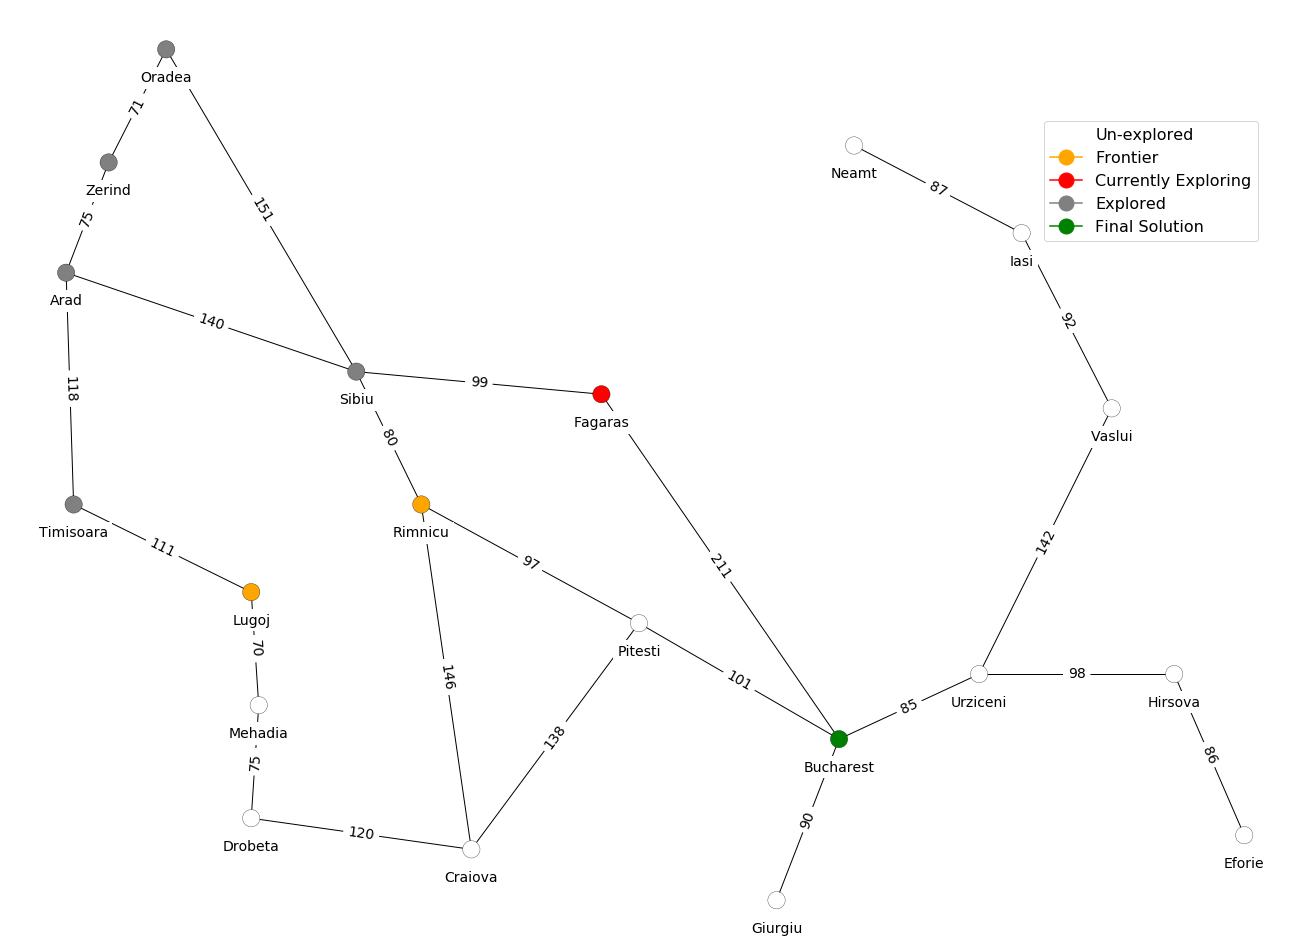

In [9]:
current_node_colors = {}
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

iterations, current_node_colors, node = breadth_first_search_graph(romania_problem)

new_romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': current_node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }
show_map(new_romania_graph_data)

## Agora é sua vez

Para cada uma das duas abordagens de busca cega, verifique o número de iterações e o tempo que o algoritmo demorou para executar. Para deixar sua análise mais interessante, faça 30 medições para cada par de cidades diferentes, ou seja, entre Arad e todas as outras cidades, entre Zerind e todas as outras cidades, etc.

Após medir o número de iterações e o tempo de execução de cada algoritmo, veja a média, mediana, desvio padrão para cada um dos algoritmos e responda: **Para este conjunto de dados, qual algoritmo é melhor?**


Dica - para pegar as cidades, basta pegar as chaves do dicionário de localizações:

```
list(romania_map.locations.keys())
```

Dica 2 - para medir o tempo de cada execução, basta utilizar este código: 
```
start_time = time.time()
# função de busca 
elapsed_time = time.time() - start_time
```



##Teste com Busca em Profundidade

In [10]:
import statistics as st

elapsed_time_list_ar = []
iterations_ar = []

for city1 in romania_map.locations.keys():
    for city2 in romania_map.locations.keys():
        for x in range(0,30):
            start_time = time.time()
            current_node_colors = {}
            romania_problem = GraphProblem(city1, city2, romania_map)

            iterations, current_node_colors, node = graph_search_for_vis(romania_problem)

            new_romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                                    'node_colors': current_node_colors,
                                    'node_positions': node_positions,
                                    'node_label_positions': node_label_pos,
                                     'edge_weights': edge_weights
                                 }
            #show_map(new_romania_graph_data)
            elapsed_time = time.time() - start_time
            
            elapsed_time_list_ar.append(elapsed_time)
            
            iterations_ar.append(iterations)

iterationsMean = st.mean(elapsed_time_list_ar)
iterationsMedian = st.median(elapsed_time_list_ar)
iterationsStdDev = st.stdev(elapsed_time_list_ar)

elapsedTimeMean = st.mean(iterations_ar)
elapsedTimeMeadian = st.median(iterations_ar)
elapsedTimeStdDev = st.stdev(iterations_ar)

print("### Run Analysis ### \nElapsed Time Mean: {0}, Elapsed Time Median: {1}, Elapsed time StdDev: {2} \nIterations Mean: {3}, Iterations Median: {4}, Iterations StdDev: {5}"
      .format(iterationsMean, iterationsMedian, iterationsStdDev, elapsedTimeMean, elapsedTimeMeadian, elapsedTimeStdDev))
           

### Run Analysis ### 
Elapsed Time Mean: 0.0001283165415128072, Elapsed Time Median: 0.00013113021850585938, Elapsed time StdDev: 7.122439371570637e-05 
Iterations Mean: 58.09, Iterations Median: 60.5, Iterations StdDev: 35.2628064981624


##Teste com Busca em Largura

In [11]:
import statistics as st

elapsed_time_list_ar = []
iterations_ar = []

for city1 in romania_map.locations.keys():
    for city2 in romania_map.locations.keys():
        for x in range(0,30):
            start_time = time.time()
            current_node_colors = {}
            romania_problem = GraphProblem(city1, city2, romania_map)

            iterations, current_node_colors, node = breadth_first_search_graph(romania_problem)

            new_romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                                    'node_colors': current_node_colors,
                                    'node_positions': node_positions,
                                    'node_label_positions': node_label_pos,
                                     'edge_weights': edge_weights
                                 }
            #show_map(new_romania_graph_data)
            elapsed_time = time.time() - start_time

            elapsed_time_list_ar.append(elapsed_time)

            iterations_ar.append(iterations)

iterationsMean = st.mean(elapsed_time_list_ar)
iterationsMedian = st.median(elapsed_time_list_ar)
iterationsStdDev = st.stdev(elapsed_time_list_ar)

elapsedTimeMean = st.mean(iterations_ar)
elapsedTimeMeadian = st.median(iterations_ar)
elapsedTimeStdDev = st.stdev(iterations_ar)

print("### Run Analysis ### \nElapsed Time Mean: {0}, Elapsed Time Median: {1}, Elapsed time StdDev: {2} \nIterations Mean: {3}, Iterations Median: {4}, Iterations StdDev: {5}"
      .format(iterationsMean, iterationsMedian, iterationsStdDev, elapsedTimeMean, elapsedTimeMeadian, elapsedTimeStdDev))

### Run Analysis ### 
Elapsed Time Mean: 8.23527177174886e-05, Elapsed Time Median: 7.43865966796875e-05, Elapsed time StdDev: 5.0835097717800266e-05 
Iterations Mean: 25.22, Iterations Median: 23.0, Iterations StdDev: 16.34759524586191


##Qual algoritmo é o melhor?
Para este conjunto de dados, tanto em se tratando de tempo de execução quanto em número de iterações a busca em largura é melhor, pois acha o destino com menos iterações e o tempo de execução é menor além da previsibilidade do tempo de execução (desvio padrão) em relação a tempo e quantidade de iterações ser menor também.  